In [ ]:
# default_exp fastai-sequence

# Action Recognition using Fastai

> Ref. [3D Resnet for NIfTI images](https://gist.github.com/jcreinhold/78943cdeca1c5fca4a5af5d066bd8a8d)

In [ ]:
import cv2
from PIL import Image

import fastai
from fastai.vision import *
from fastai.vision.transform import *
import torchvision.transforms as transforms

from fastai.metrics import error_rate, accuracy

from actions_in_videos.dataset_ucf101 import UCF101
from actions_in_videos.avi import AVI

In [ ]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline

In [ ]:
print(f'fastai version: {fastai.__version__}')
print(f'pytorch version: {torch.__version__}')
#print(f'torchvision version: {torchvision.__version__}')

fastai version: 1.0.60
pytorch version: 1.4.0


In [ ]:
# data_path = '/home/jupyter/Action-Recognition/data/UCF-101-frames'

## Custom DataSets in Fastai
> ref. https://docs.fast.ai/basic_data.html#DataBunch

In [ ]:
# #export
# class SequenceDataset(Dataset):
#     """Sequence based dataset for the UCF101.
    
#     Output is of shape:
#         seq_len, H, W, C
        
#     Note that when this is passed onto a DataLoader with toTensor() transform, it changes its shape to:
#         batch_size, seq_length, C, H, W 
        
#     """

#     def __init__(self, dataset_path, sequence_length, sample_interval=1, training=True, transform=None, safe=True, verbose=False, smaller_dataset=False):
#         """
#         Args:            
#             file_list: list of files as a numpy array.
#             labels: one entry per filename in the list of files as a numpy array.
#             train: flag to say whether train or test dataset is used.
#             transform (callable, optional): Optional transform to be applied
#                 on a sample.
#         """
#         self.sequence_length = sequence_length
#         self.sample_interval = sample_interval
#         self.training = training
#         self.safe = safe # impacts the getSequence method of the AVI class accessed through getRandomSequence method.
#         self.verbose = verbose

#         ucf = UCF101(dataset_path)
        
#         X, class_names = ucf.getFileList(data_type='train' if training else 'test', smaller_dataset=smaller_dataset)
#         self.file_list, self.labels = X[0], X[1]
#         self.class_names = class_names
#         self.c = len(self.class_names)
#         self.transform = transform
        
#     def setVerbose(self, flag=False):
#         self.verbose=flag
            
#     def getClassName(self, idx):
#         return self.class_names[idx]
    
#     def getFileName(self, idx):
#         return self.file_list[idx]

#     def __len__(self):
#         return len(self.file_list)

#     def loadSequence(self, args):
#         mean = np.asarray([0.433, 0.4045, 0.3776],np.float32)
#         std = np.asarray([0.1519876, 0.14855877, 0.156976],np.float32)

#         curr_w = 320
#         curr_h = 240
#         height = width = 224
#         num_of_frames=16

#         (filename,augment) = args    

#         data = np.zeros((3,num_of_frames,height,width),dtype=np.float32)
#         try:
#             ### load file from AVI
#             cap = cv2.VideoCapture(filename)   
#             if not cap.isOpened(): 
#                 print(f"could not open {filename}") 
#                 return
#             nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#             #frameWidth   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#             #frameHeight  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#             fps     = cap.get(cv2.CAP_PROP_FPS)

#             frame_index = np.random.randint(nFrames - num_of_frames)
#             cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            
#             #print(f'Frame-index-0: {frame_index}')
#             video = []        
#             f_count = 0
#             while cap.isOpened() and f_count < num_of_frames:
#                 frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
#                 ret, frame = cap.read() 
#                 video.append(frame)
#                 f_count += 1

#             cap.release()

#             if(augment==True):
#                 ## RANDOM CROP - crop 70-100% of original size
#                 ## don't maintain aspect ratio
#                 resize_factor_w = 0.3*np.random.rand()+0.7
#                 resize_factor_h = 0.3*np.random.rand()+0.7
#                 w1 = int(curr_w*resize_factor_w)
#                 h1 = int(curr_h*resize_factor_h)
#                 w = np.random.randint(curr_w-w1)
#                 h = np.random.randint(curr_h-h1)
#                 random_crop = np.random.randint(2)

#                 ## Random Flip
#                 random_flip = np.random.randint(2)

#                 ## Brightness +/- 15
#                 brightness = 30
#                 random_add = np.random.randint(brightness+1) - brightness/2.0

#                 data = []
#                 for frame in video:
#                     if(random_crop):
#                         frame = frame[h:(h+h1),w:(w+w1),:]
#                     if(random_flip):
#                         frame = cv2.flip(frame,1)
#                     frame = cv2.resize(frame,(width,height))
#                     frame = frame.astype(np.float32)

#                     frame += random_add
#                     frame[frame>255] = 255.0
#                     frame[frame<0] = 0.0

#                     frame = frame/255.0
#                     frame = (frame - mean)/std
#                     data.append(frame)
#                 data = np.asarray(data)

#             else:
#                 # don't augment
#                 data = []
#                 for frame in video:
#                     frame = cv2.resize(frame,(width,height))
#                     frame = frame.astype(np.float32)
#                     frame = frame/255.0
#                     frame = (frame - mean)/std
#                     data.append(frame)
#                 data = np.asarray(data)

#             data = data.transpose(3,0,1,2)            
#         except:
#             print("\nException: " + filename)
#             data = np.array([])
#         return data
        
    
#     def __getitem__(self, idx):
#         """
#         Args:
#         - idx: item index
#         returns: 
#         - sequence: list of frames of length self.sequence_length
#         """
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
#         video_list = self.file_list[idx]
#         #video_list = self.file_list[idx % len(self)] # wraps up if an out of index idx is used.
#         arg = (video_list, self.training)
#         frames = self.loadSequence(arg)
#         label = self.labels[idx]
#         label = np.array([label])                        
#         return frames, label
            

In [ ]:
# train_ds = SequenceDataset(dataset_path='../data/UCF101/', 
#                            sequence_length=16, 
#                            training=True, 
#                            transform=None, 
#                            verbose=True, 
#                            smaller_dataset=False)

# valid_ds = SequenceDataset(dataset_path='../data/UCF101/', 
#                            sequence_length=16, 
#                            training=False, 
#                            transform=None, 
#                            verbose=True, 
#                            smaller_dataset=False)

# print(f"Num of classes: {train_ds.c}")

In [ ]:
# #export
# class SingleFrameDataset(Dataset):
#     """Single frame dataset for the UCF101."""

#     def __init__(self, dataset_path, training=True, img_type=np.float32, transform=None, verbose=False, smaller_dataset=False):
#         """
#         Args:            
#             file_list: list of files as a numpy array.
#             labels: one entry per filename in the list of files as a numpy array.
#             train: flag to say whether train or test dataset is used.
#             transform (callable, optional): Optional transform to be applied
#                 on a sample.
#         """
#         self.verbose = verbose
#         self.training = True
#         ucf = UCF101(dataset_path)
        
#         X, class_names = ucf.getFileList(data_type='train' if training else 'test', smaller_dataset=smaller_dataset)
#         self.file_list, self.labels = X[0], X[1]
#         self.class_names = class_names
#         self.c = len(self.class_names)
#         self.img_type = img_type
#         self.transform = transform
        
#     def setVerbose(self, flag=False):
#         self.verbose=flag
        
#     def getClassName(self, idx):
#         return self.class_names[idx]
    
#     def getFileName(self, idx):
#         return self.file_list[idx]

#     def __len__(self):
#         return len(self.file_list)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
#         video_list = self.file_list[idx]
#         #video_list = self.file_list[idx % len(self)] # wraps up if an out of index idx is used.
#         avi = AVI(video_list, verbose=self.verbose, img_type=self.img_type)
                
#         frame = avi.getRandomFrame()
                                            
#         label = self.labels[idx]
#         label = np.array(label)

#         if self.transform:
# #            frame = frame.transpose(2,0,1)
#             frame = self.transform(frame)                
            
#         return frame, label
            

In [ ]:
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

In [ ]:
# # Define training set
# train_ds = SingleFrameDataset(
#                 dataset_path='../data/UCF101/',
#                 training=True,
#                 img_type=np.uint8,
#                 transform=transforms.Compose(
#                 [
#                     transforms.ToPILImage(),
#                     transforms.RandomHorizontalFlip(p=0.5),
#                     transforms.RandomCrop((224, 224)),
#                     transforms.Resize((224, 224)), 
#                     transforms.ToTensor(), 
#                     transforms.Normalize(mean, std),
#                 ])
#             )

# # Define test set
# test_ds = SingleFrameDataset(
#             dataset_path='../data/UCF101/',
#             training=False,
#             img_type=np.uint8,
#             transform=transforms.Compose(
#             [
#                 transforms.ToPILImage(),
#                 transforms.Resize((224, 224)), 
#                 transforms.ToTensor(), 
#                 transforms.Normalize(mean, std),
#             ])
#         )

# print(f"Num of classes: {train_ds.c}")

In [ ]:
# data = DataBunch.create(train_ds, valid_ds, bs=32, num_workers=4)

In [ ]:
# data.one_batch()[0].shape

## Custom ItemList

> ref.  
https://docs.fast.ai/tutorial.itemlist.html  
https://blog.usejournal.com/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4  
https://docs.fast.ai/tutorial.itemlist.html

In [ ]:
class SingleFrame(ItemBase): 
    """ Two main functions are all you need to create your custom ItemBase. 
        It is not usable until you have put it inside your custom ItemList though."""
    def __init__(self, img):
        self.obj = img   # initial object 
        self.img = img
        self.data = -1+2*img.data
        
    def apply_tfms(self, tfms, **kwargs):        
        self.img = self.img.apply_tfms(tfms, **kwargs)
        self.data = -1+2*self.img.data
        return self
    
    def __repr__(self):
        return f'{self.__class__.__name__}({self.img.shape})'
     
    # def to_one(self): return Image(0.5+torch.cat(self.data,2)/2) # something like this might be used to concat more than one imgs into one..

In [ ]:
# Subclass ImageList to use our own image opening function
class SingleFrameList(ItemList):    
    """This is the main class that allows you to group your inputs or your targets in the data block API. 
       You can then use any of the splitting or labelling methods before creating a DataBunch."""
    # _bunch
    # _processor
    _label_cls=None
    def __init__(self, items, **kwargs):
        super().__init__(items, **kwargs)        
      
    def open(self, fn:PathOrStr)->Image:
        avi = AVI(fn, verbose=True, img_type=np.float32)
        img = avi.getRandomFrame()        
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))

    def get(self, i):
        "Defines how to construct an ItemBase from the data in the ItemList.items array"
        #print('h')
        fn = super().get(i)
        res = self.open(fn)
        #self.sizes[i] = res.size
        return SingleFrame(res)
    
    def reconstruct(self, t:Tensor): 
        # It should take a tensor t and return the same kind of thing as the get method.
        return SingleFrame(vision.Image(t)) # might do some denormalisation here. Not sure it is needed.
        
    @classmethod
    def from_folder(cls, path, **kwargs):
        res = super().from_folder(path, **kwargs)
        res.path = path
        return res
    
    def split_by_files(self, names):
        return self.split_by_valid_func(lambda o: any(o.name in vn for vn in names))
    
    def split_by_fname_file(self, fname, path=None, **kwargs):        
        "Split the data by using the names in `fname` for the validation set. `path` will override `self.path`."        
        path = Path(ifnone(path, self.path))
        relative_valid_names = loadtxt_str(path/fname)
        valid_names = [str(Path(self.path).joinpath(Path(fn))) for fn in relative_valid_names]        
        return self.split_by_files(valid_names)        
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        print(xs[0].data)
        import pdb
        pdb.set_trace()
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        print('HelloS')
        figsize = ifnone(figsize, (12, 3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.show(ax=axs[i,0], **kwargs)
            axs[i].title(z)
            #z.to_one().show(ax=axs[i,1], **kwargs)
    

In [ ]:
class SingleFrame(Image): 
    """ Two main functions are all you need to create your custom ItemBase. 
        It is not usable until you have put it inside your custom ItemList though."""
    def __init__(self, img):
        super().__init_
        self.obj = img   # initial object 
        self.img = img
        self.data = img.data
        
#     def apply_tfms(self, tfms, **kwargs):        
#         self.img = self.img.apply_tfms(tfms, **kwargs)
#         self.data = self.img.data
#         return self
    
#     def __repr__(self):
#         return f'{self.__class__.__name__}({self.img.shape})'
     


In [ ]:
# Subclass ImageList to use our own image opening function
class SingleFrameList(ItemList): #(ItemList):    
    """This is the main class that allows you to group your inputs or your targets in the data block API. 
       You can then use any of the splitting or labelling methods before creating a DataBunch."""
    # _bunch
    # _processor
    _label_cls=None  # If set to one, fastai selects one class that should fit.
    def __init__(self, items, **kwargs):
        super().__init__(items, **kwargs)        
      
    def open(self, fn:PathOrStr)->Image:
        avi = AVI(fn, verbose=True, img_type=np.float32)
        x = avi.getRandomFrame()        
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        x = pil2tensor(x,np.float32)
        x.div_(255)            
        return vision.Image(x)    
    
    def get(self, i):
        "Defines how to construct an ItemBase from the data in the ItemList.items array"
        fn = super().get(i)
        res = self.open(fn)
#        return SingleFrame(res)
        return res
    
    def reconstruct(self, t:Tensor): 
        return vision.Image(t.float().clamp(min=0,max=1))
        #return SingleFrame(vision.Image(t.float().clamp(min=0,max=1)))
    
    @classmethod
    def from_folder(cls, path, **kwargs):
        res = super().from_folder(path, **kwargs)
        res.path = path
        return res
    
    def split_by_files(self, names):
        return self.split_by_valid_func(lambda o: any(o.name in vn for vn in names))
    
    def split_by_fname_file(self, fname, path=None, **kwargs):        
        "Split the data by using the names in `fname` for the validation set. `path` will override `self.path`."        
        path = Path(ifnone(path, self.path))
        relative_valid_names = loadtxt_str(path/fname)
        valid_names = [str(Path(self.path).joinpath(Path(fn))) for fn in relative_valid_names]        
        return self.split_by_files(valid_names)        
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        #print(xs[0].data)
        #import pdb
        #pdb.set_trace()
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        print('HelloS')
        figsize = ifnone(figsize, (12, 3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.show(ax=axs[i,0], **kwargs)
            axs[i].title(z)
            #z.to_one().show(ax=axs[i,1], **kwargs)

In [ ]:
data = (SingleFrameList.from_folder('../data/UCF101/UCF-101/'))

In [ ]:
data.items

array([PosixPath('../data/UCF101/UCF-101/HandstandWalking/v_HandstandWalking_g10_c04.avi'),
       PosixPath('../data/UCF101/UCF-101/HandstandWalking/v_HandstandWalking_g17_c01.avi'),
       PosixPath('../data/UCF101/UCF-101/HandstandWalking/v_HandstandWalking_g06_c04.avi'),
       PosixPath('../data/UCF101/UCF-101/HandstandWalking/v_HandstandWalking_g05_c02.avi'), ...,
       PosixPath('../data/UCF101/UCF-101/Punch/v_Punch_g15_c01.avi'),
       PosixPath('../data/UCF101/UCF-101/Punch/v_Punch_g05_c02.avi'),
       PosixPath('../data/UCF101/UCF-101/Punch/v_Punch_g04_c03.avi'),
       PosixPath('../data/UCF101/UCF-101/Punch/v_Punch_g24_c02.avi')], dtype=object)

In [ ]:
# data = data.split_by_fname_file(fname='testlist01.txt', path='../data/UCF101/UCF-101/../annotations/ucfTrainTestlist/')

In [ ]:
# data.label_from_func(get_y_fn, classes=codes)Andrea

In [ ]:
def get_y_func(o):
    return str(o.parents[0]).split('/')[-1]

get_y = lambda o:str(o.parents[0]).split('/')[-1]

tfms = get_transforms(do_flip=True, flip_vert=False)

data_path = '../data/UCF101/UCF-101/'

In [ ]:
data = (SingleFrameList.from_folder(data_path) #Where to find the data? -> in path and its subfolders
        .split_by_fname_file(fname='testlist01.txt', path='../data/UCF101/annotations/ucfTrainTestlist/')             #How to split in train/valid? -> use the folders
        .label_from_func(get_y_func)         #How to label
#        .add_test_folder()              #Optionally add a test set (here default name is test)
#        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 224
        .databunch())    

In [ ]:
# data.show_batch()

In [ ]:
x, y = data.one_batch()

In [ ]:
fig, ax = plt.subplots()

SingleFrame(Image(x[0].permute(1,2,0))).show(ax)

In [ ]:
plt.imshow(x[0].permute(1,2,0)/255), y[0]

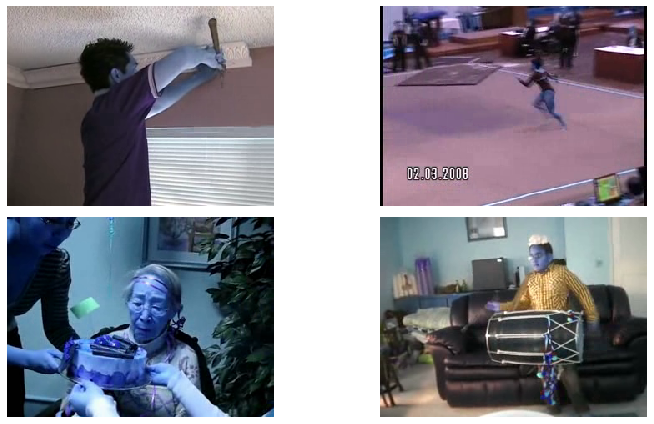

In [ ]:
data.show_batch()

In [ ]:
rows=5


In [ ]:
data.train_dl.batch_size

In [ ]:
xs = [data.train_ds.x.reconstruct(grab_idx(x, 0)), data.train_ds.x.reconstruct(grab_idx(x, 1))]

In [ ]:
xs

In [ ]:
ys = [data.train_ds.y.reconstruct(grab_idx(y, 0)), data.train_ds.y.reconstruct(grab_idx(y, 1))]

In [ ]:
ys

In [ ]:
def showxy(xs, ys):
    rows = int(math.sqrt(len(xs)))
#     print(xs[0].data)
#     import pdb
#     pdb.set_trace()
    fig, axs = plt.subplots(rows,rows,figsize=(10,10))
    for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
        xs[i].show(ax=ax)#, **kwargs)
    plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(10,10))
xs[0].show(ax=axs)

In [ ]:
showxy(xs, ys)

In [ ]:
ItemBase.show??

In [ ]:
# data.train_ds.y.classes

In [ ]:
# idx = next(iter(data.train_dl.batch_sampler))
# samples=[]
# for i in idx:
#     samples.append(data.train_dl.dataset[i])
    
# recurse(lambda x: x.data, samples)
# batch = data.collate_fn(samples)
# data.valid_ds[100]

In [ ]:
data.one_item??

In [ ]:
!ls ../data/UCF101/UCF-101/HandstandWalking/v_HandstandWalking_g10_c04.avi

In [ ]:
%debug

In [ ]:
data.show_xys()

In [ ]:
# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageList):
    """This is the main class that allows you to group your inputs or your targets in the data block API. 
       You can then use any of the splitting or labelling methods before creating a DataBunch."""
    def open(self, fn:PathOrStr)->Image:
        avi = AVI(fn, verbose=False, img_type=np.float32)
        img = avi.getRandomFrame()
        
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))

In [ ]:
dataset_path = '../data/UCF101/'
ucf = UCF101(dataset_path)
        
data_files, classes, class_names = ucf.getFileListAndClasses(data_type='train', smaller_dataset=True)
 
print(data_files[0])    
imglist = MyImageItemList()    
#img = imglist.open(data_files[0])

In [ ]:
data_files

### Applies transform and use label_from_func to extract class labels

In [ ]:
def get_y_func(o):
    return str(o.parents[1]).split('/')[-1]
    
get_y = lambda o:str(o.parents[1]).split('/')[-1]

In [ ]:
tfms = get_transforms(do_flip=True, flip_vert=False)

In [ ]:
#tfms

In [ ]:
ImageList.from_folder.split_by_files??

In [ ]:
data = (ImageList.from_folder(data_path) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()             #How to split in train/valid? -> use the folders
        .label_from_func(get_y)          #How to label? -> depending on the folder of the filenames
        .add_test_folder()               #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 224
        .databunch())    

In [ ]:
Andrea Munafòdata.show_batch(3, figsize=(20,20), hide_axis=True)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1,1e-5)

In [ ]:
learn.save('fastai-1')

In [ ]:
learn.unfreezefreeze()

In [ ]:
learn.fit_one_cycle(1,1e-2)

In [ ]:
learn.save('fastai-2')

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

interp.plot_top_losses(9, figsize=(7,7))